In [20]:
pip install kaggle


In [21]:
pip install --user kaggle


In [22]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sujalkumarnayak","key":"fa05b90dc06b6bad6195061abb0a438b"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d uom190346a/sleep-health-and-lifestyle-dataset


In [ ]:
!unzip sleep-health-and-lifestyle-dataset.zip -d sleep_dataset #unzip the files


Archive:  sleep-health-and-lifestyle-dataset.zip
replace sleep_dataset/Sleep_health_and_lifestyle_dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
os.listdir("sleep_dataset")
#verifyng files

In [ ]:
import pandas as pd
df = pd.read_csv("sleep_dataset/Sleep_health_and_lifestyle_dataset.csv")
df.head()
#loading into pandas

In [ ]:
import pandas as pd
import numpy as np
import re
pd.options.display.max_columns = 200           #basic EDA

PATH = "sleep_dataset/Sleep_health_and_lifestyle_dataset.csv"
df = pd.read_csv(PATH, low_memory=False)

print("ROWS, COLS:", df.shape)
print("\nFIRST 20 COLUMN NAMES:")
for i, c in enumerate(df.columns[:20], start=1):
    print(i, c)

# check missingness and dtypes summary
missing = (df.isnull().mean() * 100).sort_values(ascending=False)
print("\nTOP 10 COLUMNS BY MISSING PERCENT:")
print(missing.head(10))

print("\nDTYPES COUNTS:")
print(df.dtypes.value_counts())
#will display column names, missingness,not any obvious sleep scores or PSQI fields

In [ ]:
def find(patterns):
    cols = df.columns.tolist()
    for pat in patterns:
        for c in cols:
            if re.search(pat, c, flags=re.IGNORECASE):
                return c
    return None             #auto detect likely useful columns for labels and lifestyle

insomnia_col = find([r"insomnia", r"sleep_problem", r"trouble_sleep", r"sleep_disorder"])
psqi_col = find([r"psqi", r"pittsburgh"])
sleep_quality_col = find([r"sleep_quality", r"subjective_sleep", r"sleepquality"])
total_sleep_col = find([r"sleep_duration", r"total_sleep", r"hours_sleep", r"hours"])
sleep_latency_col = find([r"sleep_latency", r"latency", r"time_to_sleep", r"minutes_to_sleep"])
awakenings_col = find([r"awakenings", r"wake_count", r"wakeups", r"wake"])
caffeine_col = find([r"caffeine", r"coffee"])
alcohol_col = find([r"alcohol", r"drinks"])
stress_col = find([r"stress", r"anxiety", r"stress_level", r"stressscore"])

print("\nDETECTED COLUMNS:")
print("insomnia_col", insomnia_col)
print("psqi_col", psqi_col)
print("sleep_quality_col", sleep_quality_col)
print("total_sleep_col", total_sleep_col)
print("sleep_latency_col", sleep_latency_col)
print("awakenings_col", awakenings_col)
print("caffeine_col", caffeine_col)
print("alcohol_col", alcohol_col)
print("stress_col", stress_col)

print("\nSAMPLE ROWS")
display(df.head(3))

In [ ]:
# Label creation for early insomnia risk
import pandas as pd
import numpy as np


df.columns = df.columns.str.strip()  # remove spaces

# Risk = 1,likely early insomnia if
# Sleep Duration < 6.5 hrs or quality of sleep <6 or Stress Level >= 7
# Otherwise, 0 (normal condition)
def make_label(row):
    try:
        sleep_dur = float(row["Sleep Duration"])
    except:
        sleep_dur = np.nan
    try:
        sleep_quality = float(row["Quality of Sleep"])
    except:
        sleep_quality = np.nan
    try:
        stress = float(row["Stress Level"])
    except:
        stress = np.nan

    if (not np.isnan(sleep_dur) and sleep_dur < 6.5) or \
       (not np.isnan(sleep_quality) and sleep_quality <= 6) or \
       (not np.isnan(stress) and stress >= 7):
        return 1
    else:
        return 0

df["label_insomnia_risk"] = df.apply(make_label, axis=1)

print("Label distribution (0 = normal, 1 = early risk):")
print(df["label_insomnia_risk"].value_counts())
df[["Sleep Duration","Quality of Sleep","Stress Level","label_insomnia_risk"]].head(10)


In [ ]:
# Feature Engineering and Preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# 1. Encode categorical columns
cat_cols = ["Gender", "Occupation", "BMI Category", "Blood Pressure", "Sleep Disorder"]
num_cols = ["Age", "Sleep Duration", "Quality of Sleep", "Physical Activity Level", "Stress Level", "Heart Rate", "Daily Steps"]

# Fill missing values with "Unknown"
for c in cat_cols:
    if c in df.columns:
        df[c] = df[c].fillna("Unknown")
        df[c] = df[c].astype(str)

# Convert categorical to dummy variables
df_encoded = pd.get_dummies(df[cat_cols], drop_first=True)

# Combine numeric + encoded categorical + label
df_final = pd.concat([df[num_cols], df_encoded, df["label_insomnia_risk"]], axis=1)

print("Final feature columns:", len(df_final.columns) - 1)
print("Rows:", df_final.shape[0])

#Splitting into train and test sets
# Split data
X = df_final.drop("label_insomnia_risk", axis=1)
y = df_final["label_insomnia_risk"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Scale numeric data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train shape:", X_train_scaled.shape)
print("Test shape:", X_test_scaled.shape)

# Save data for next step
import joblib
joblib.dump((X_train_scaled, X_test_scaled, y_train.values, y_test.values, X.columns.tolist()), "sleep_data_splits.joblib")
print("Saved preprocessed data to sleep_data_splits.joblib")


In [ ]:
# Model Building and Training
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils import class_weight
import joblib
import numpy as np

# Load preprocessed data
X_train, X_test, y_train, y_test, feature_names = joblib.load("sleep_data_splits.joblib")

# Compute class weights for balance (in order to prevent biases)
cw = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(y_train), y=y_train
)
class_weights = {i: w for i, w in enumerate(cw)}
print("Class Weights:", class_weights)

# Build the model
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=80,
    batch_size=16,
    class_weight=class_weights,
    callbacks=[es],
    verbose=1
)

# Save model
model.save("insomnia_model.h5")
print("Model saved as insomnia_model.h5")

# Evaluation
preds = model.predict(X_test).ravel()
pred_labels = (preds >= 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, pred_labels))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred_labels))
print("ROC-AUC:", roc_auc_score(y_test, preds))


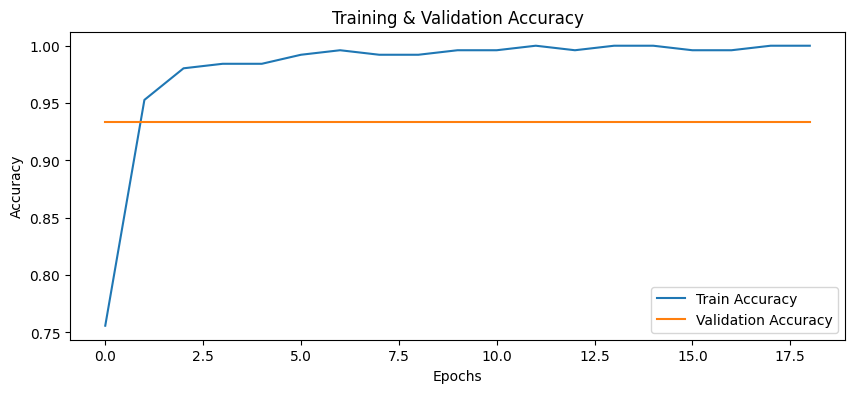

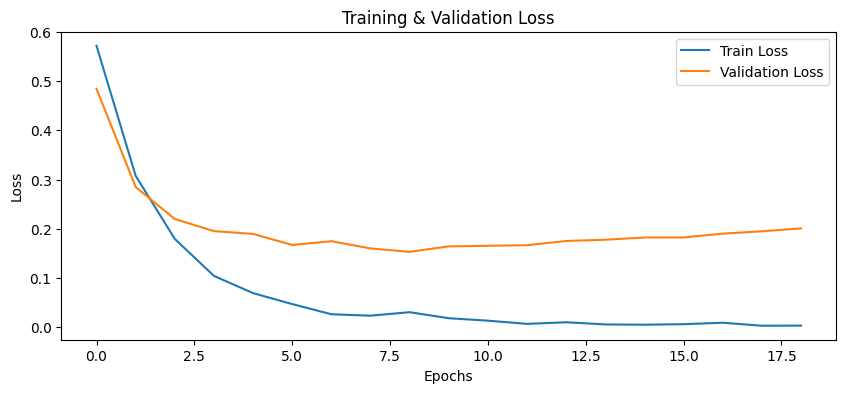

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


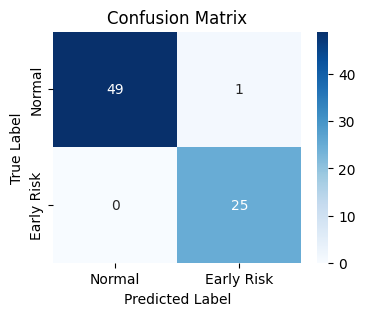

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step 


  0%|          | 0/75 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 7s 988us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 7s 990us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6607/6607 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
6607/6607 ━━━━━━━━━━━━━━━━━━━━ 7s 996us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━

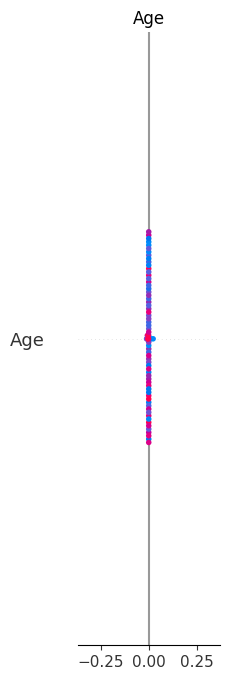

In [19]:
# Visualization and Interpretation
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import numpy as np
from tensorflow.keras.models import load_model
import joblib

# Reload everything
model = load_model("insomnia_model.h5")
X_train, X_test, y_train, y_test, feature_names = joblib.load("sleep_data_splits.joblib")

# Accuracy and loss curves
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix heatmap
from sklearn.metrics import confusion_matrix
preds = model.predict(X_test).ravel()
pred_labels = (preds >= 0.5).astype(int)
cm = confusion_matrix(y_test, pred_labels)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Early Risk'], yticklabels=['Normal','Early Risk'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# SHAP Feature Importance
# Using smaller subset for faster computation
explainer = shap.KernelExplainer(lambda x: model.predict(x), shap.sample(X_train, 100))
shap_values = explainer.shap_values(shap.sample(X_test, 100))
shap.summary_plot(shap_values, shap.sample(X_test, 100), feature_names=feature_names)
